In [1]:
import numpy as np
  
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import concatenate, LeakyReLU, BatchNormalization, Dense, Activation, Reshape
from keras.optimizers import *
from keras.datasets import mnist

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

(X_train, _), (_, _) = mnist.load_data()
X_train = np.reshape(X_train, (-1, 28, 28, 1))/255

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
from typing import List
from unet import unet_cell, LEAKY_RELU_ALPHA, BATCH_NORM_MOMENTUM # Local import

In [3]:
# Note: Support for type hints only in Python >= 3.5
def build_upscaler(inputs: Input,
                   num_filters_in_layer: List[int]=[16, 32, 64],
                   num_cells_in_layer: List[int]=[3, 3, 3],
                   bottleneck_before_concat: bool=False) -> Model:
    """Build a model which upscales inputs by factor of 4 (i.e., 
       doubles the height and width of inputs)
    
    # Arguments
    
    # Returns
    """
    # Validate inputs
    if len(num_filters_in_layer) != len(num_cells_in_layer):
        raise ValueError("len(num_filters_in_layer) should equal "
            "len(num_cells_in_layer). Received lengths: "
            "({}, {})".format(len(num_filters_in_layer), len(num_cells_in_layer)))
    
    x = inputs
    x = UpSampling2D()(x)
    carry_forward_tensors = []

    # Zip the parameters that apply to the contraction-side (exclude last 
    # parameter for bottom layer)
    contraction_filters_and_cells = zip(num_filters_in_layer[:-1],
                                        num_cells_in_layer[:-1])

    # Contraction
    for i, (num_filters, num_cells) in enumerate(contraction_filters_and_cells):
        if i == 0:
            # First layer does not downsample
            for j in range(num_cells):
                x = unet_cell(x, num_filters=num_filters) 
                # Note: We make extensive use of default values.
        else:
            # Downsample first
            x = unet_cell(x, num_filters=num_filters, strides=2)
            for j in range(num_cells - 1):
                x = unet_cell(x, num_filters=num_filters)
        carry_forward_tensors.append(x)

    # Bottom layer
    num_filters_at_bottom = num_filters_in_layer[-1]
    num_cells_at_bottom = num_cells_in_layer[-1]

    x = unet_cell(x, num_filters=num_filters_at_bottom, strides=2)
    for i in range(num_cells_at_bottom - 1):
        x = unet_cell(x, num_filters=num_filters_at_bottom)

    # Expansion
    filters_cells_and_carrys = reversed(list(zip(num_filters_in_layer[:-1],
                                                 num_cells_in_layer[:-1],
                                                 carry_forward_tensors)))
    for num_filters, num_cells, carry in filters_cells_and_carrys:
        x = unet_cell(x, transpose_conv=True, num_filters=num_filters, strides=2)
        if bottleneck_before_concat:
            x = unet_cell(x, num_filters=num_filters//2, kernel_size=1)
            carry = unet_cell(carry, num_filters=num_filters//2, kernel_size=1)
        x = concatenate([x, carry])
        for _ in range(num_cells - 1):
            x = unet_cell(x, num_filters=num_filters)

    # Output
    x = unet_cell(x, num_filters=1, kernel_size=1, activation='sigmoid',
                  batch_normalization=False)

    model = Model(inputs=inputs, outputs=x)
    return model

In [4]:
# TODO: Test keras.applications (ResNet, Xception, etc.) as discriminators
def build_discriminator(inputs: Input,
                        num_filters_in_layer: List[int]=[16, 32, 64],
                        num_cells_in_layer: List[int]=[3, 3, 3],
                        num_units_in_dense_layer: List[int]=[]):
    """Creates a (relatively standard) feed-forward convolutional classifier
    
    """
    # Validate inputs
    if len(num_filters_in_layer) != len(num_cells_in_layer):
        raise ValueError("len(num_filters_in_layer) should equal "
            "len(num_cells_in_layer). Received lengths: "
            "({}, {})".format(len(num_filters_in_layer), len(num_cells_in_layer)))
    
    x = inputs
    
    filters_and_cells = zip(num_filters_in_layer, num_cells_in_layer)
    
    for i, (num_filters, num_cells) in enumerate(filters_and_cells):
        for j in range(num_cells):
            x = unet_cell(x, num_filters=num_filters) # TODO: Rename `unet_cell`
        x = MaxPooling2D(pool_size=2)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(x)
    x = BatchNormalization(momentum=BATCH_NORM_MOMENTUM)(x)
    
    for num_units in num_units_in_dense_layer:
        x = Dense(units=num_units)(x)
        x = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(x)
        x = BatchNormalization(momentum=BATCH_NORM_MOMENTUM)(x)
    
    validity = Dense(units=1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=validity)
    return model

In [5]:
x = Input(shape=(None, None, 1))
# Note: dimensions of x should probably be divisible by 2**{num_layers}
generator = build_upscaler(x) # Use default parameters
# TODO: Rename variables to reflect purpose

optimizer = Adam(0.001, 0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

optimizer1 = Adam(0.0002, 0.5)
y = Input(shape=(None, None, 1))
discriminator = build_discriminator(y)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

discriminator.trainable = False

img = generator(x)
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# low-res image as input and returns an upsampled image from the generator and a 
# validity score given by the discriminator
combined = Model(x, [valid, img])
combined.compile(loss=['binary_crossentropy', 'mean_absolute_error'], optimizer=optimizer, metrics = ['accuracy'])

# Note that the combined model was compiled *after* freezing the discriminator's weights

combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
model_1 (Model)              (None, None, None, 1)     179969    
_________________________________________________________________
model_2 (Model)              (None, 1)                 121953    
Total params: 301,922
Trainable params: 179,009
Non-trainable params: 122,913
_________________________________________________________________


/home/ben/miniconda3/envs/tf-rocm/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.696044, acc.: 46.50%] [G loss: 0.861599]


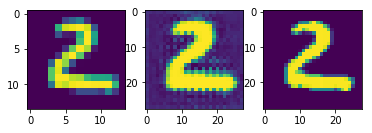

200 [D loss: 0.694283, acc.: 49.50%] [G loss: 0.782903]


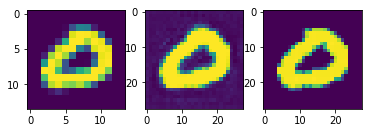

300 [D loss: 0.693804, acc.: 47.00%] [G loss: 0.745268]


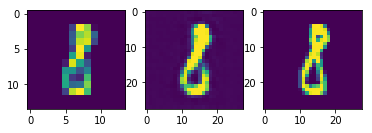

400 [D loss: 0.693631, acc.: 50.50%] [G loss: 0.728252]


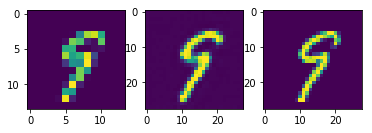

500 [D loss: 0.693554, acc.: 49.00%] [G loss: 0.720538]


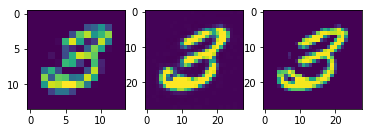

600 [D loss: 0.693507, acc.: 47.50%] [G loss: 0.715751]


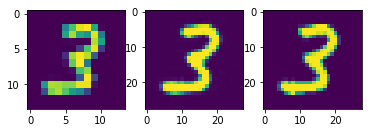

700 [D loss: 0.693467, acc.: 47.00%] [G loss: 0.712970]


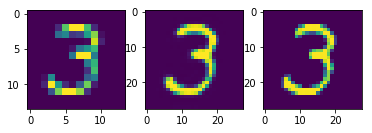

800 [D loss: 0.693444, acc.: 47.50%] [G loss: 0.712131]


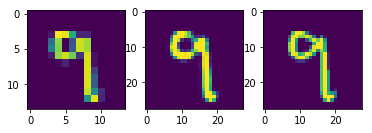

900 [D loss: 0.693416, acc.: 45.50%] [G loss: 0.710694]


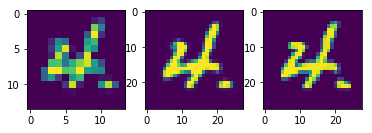

1000 [D loss: 0.693383, acc.: 45.50%] [G loss: 0.709258]


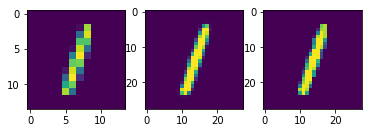

1100 [D loss: 0.693367, acc.: 46.00%] [G loss: 0.708413]


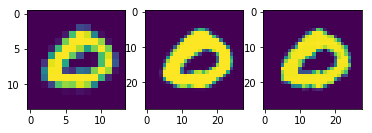

1200 [D loss: 0.693360, acc.: 52.50%] [G loss: 0.708054]


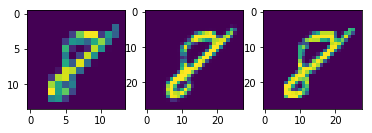

1300 [D loss: 0.693365, acc.: 50.00%] [G loss: 0.706804]


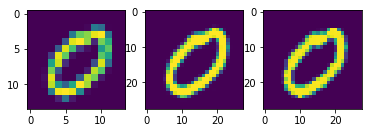

1400 [D loss: 0.693359, acc.: 48.50%] [G loss: 0.707024]


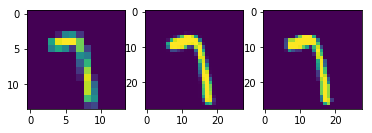

1500 [D loss: 0.693339, acc.: 49.50%] [G loss: 0.707201]


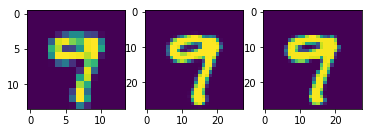

1600 [D loss: 0.693338, acc.: 49.50%] [G loss: 0.706518]


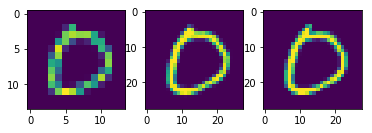

1700 [D loss: 0.693334, acc.: 45.50%] [G loss: 0.706445]


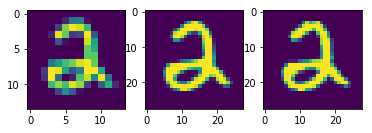

1800 [D loss: 0.693325, acc.: 50.50%] [G loss: 0.705668]


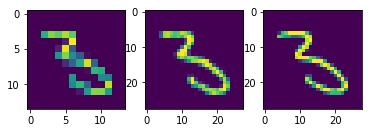

1900 [D loss: 0.693326, acc.: 49.00%] [G loss: 0.706260]


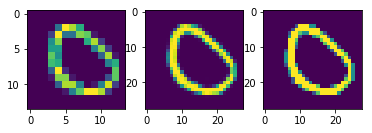

2000 [D loss: 0.693321, acc.: 46.00%] [G loss: 0.705227]


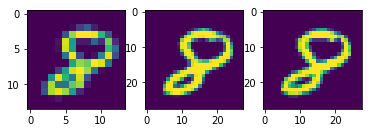

2100 [D loss: 0.693323, acc.: 46.00%] [G loss: 0.705089]


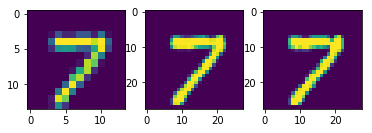

2200 [D loss: 0.693321, acc.: 47.00%] [G loss: 0.704933]


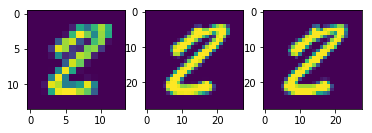

2300 [D loss: 0.693314, acc.: 53.00%] [G loss: 0.705072]


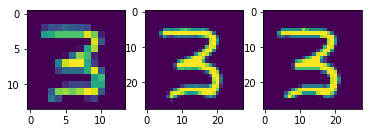

2400 [D loss: 0.693312, acc.: 46.50%] [G loss: 0.704659]


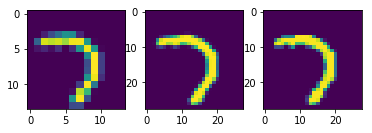

2500 [D loss: 0.693310, acc.: 49.50%] [G loss: 0.705196]


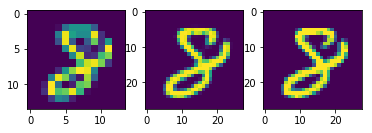

2600 [D loss: 0.693309, acc.: 49.50%] [G loss: 0.704144]


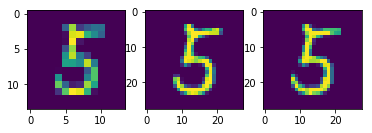

2700 [D loss: 0.693304, acc.: 49.50%] [G loss: 0.704323]


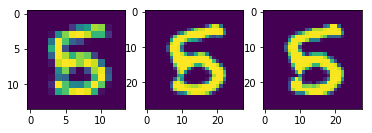

2800 [D loss: 0.693302, acc.: 46.50%] [G loss: 0.705210]


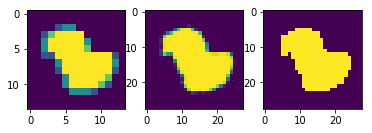

2900 [D loss: 0.693300, acc.: 52.00%] [G loss: 0.704702]


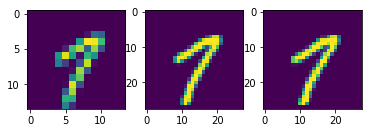

3000 [D loss: 0.693298, acc.: 49.00%] [G loss: 0.704533]


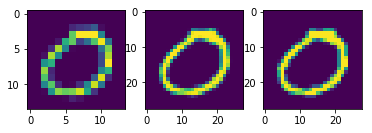

3100 [D loss: 0.693297, acc.: 47.50%] [G loss: 0.704021]


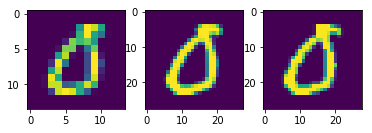

3200 [D loss: 0.693295, acc.: 49.50%] [G loss: 0.704616]


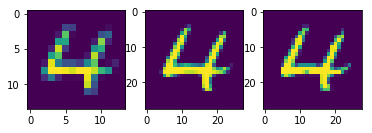

3300 [D loss: 0.693294, acc.: 46.50%] [G loss: 0.704277]


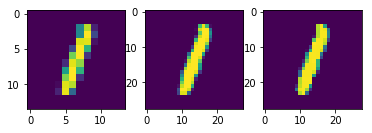

3400 [D loss: 0.693292, acc.: 50.50%] [G loss: 0.703944]


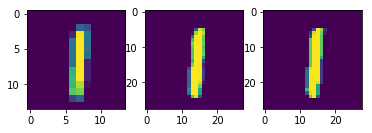

3500 [D loss: 0.693291, acc.: 44.50%] [G loss: 0.703653]


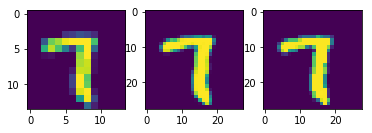

3600 [D loss: 0.693290, acc.: 53.00%] [G loss: 0.704045]


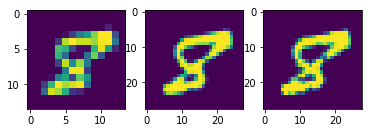

3700 [D loss: 0.693287, acc.: 45.00%] [G loss: 0.704371]


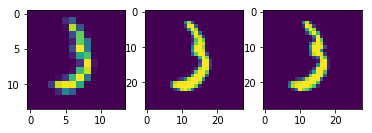

3800 [D loss: 0.693285, acc.: 45.00%] [G loss: 0.703721]


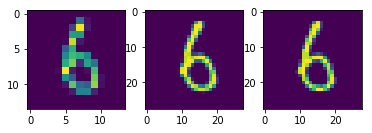

3900 [D loss: 0.693284, acc.: 43.50%] [G loss: 0.703666]


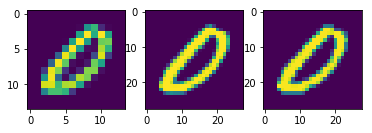

4000 [D loss: 0.693283, acc.: 45.50%] [G loss: 0.703657]


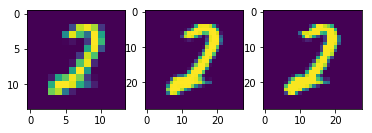

4100 [D loss: 0.693282, acc.: 48.50%] [G loss: 0.703220]


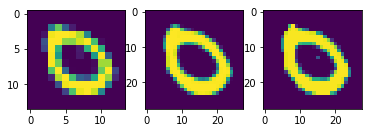

4200 [D loss: 0.693280, acc.: 53.00%] [G loss: 0.703552]


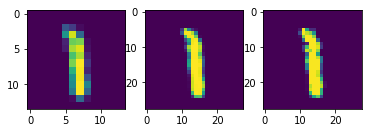

4300 [D loss: 0.693279, acc.: 44.50%] [G loss: 0.702755]


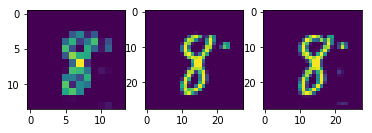

4400 [D loss: 0.693278, acc.: 41.50%] [G loss: 0.703288]


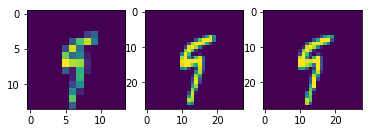

4500 [D loss: 0.693276, acc.: 48.00%] [G loss: 0.702957]


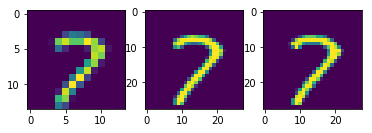

4600 [D loss: 0.693275, acc.: 43.00%] [G loss: 0.702807]


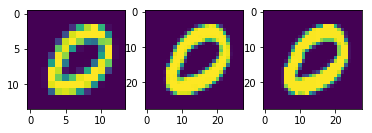

4700 [D loss: 0.693274, acc.: 43.00%] [G loss: 0.703083]


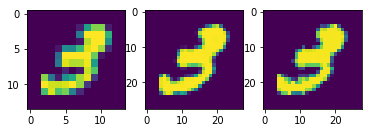

4800 [D loss: 0.693272, acc.: 44.50%] [G loss: 0.702986]


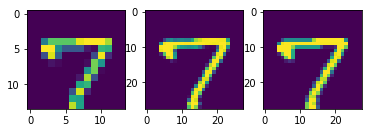

4900 [D loss: 0.693272, acc.: 52.00%] [G loss: 0.702683]


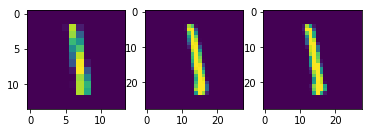

5000 [D loss: 0.693271, acc.: 43.00%] [G loss: 0.703497]


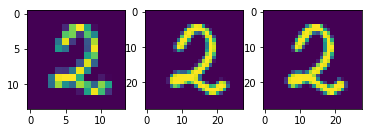

5100 [D loss: 0.693269, acc.: 42.00%] [G loss: 0.702867]


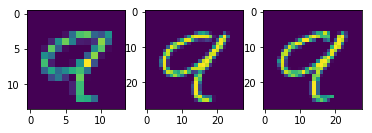

5200 [D loss: 0.693268, acc.: 43.50%] [G loss: 0.702388]


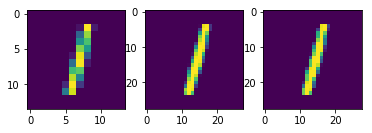

5300 [D loss: 0.693267, acc.: 40.50%] [G loss: 0.702940]


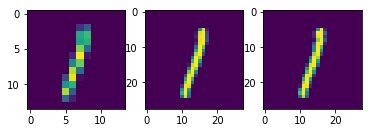

5400 [D loss: 0.693266, acc.: 45.50%] [G loss: 0.702346]


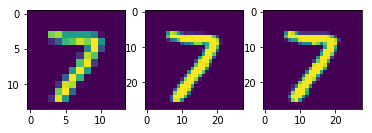

5500 [D loss: 0.693265, acc.: 40.00%] [G loss: 0.702924]


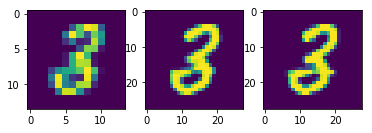

5600 [D loss: 0.693264, acc.: 37.00%] [G loss: 0.702519]


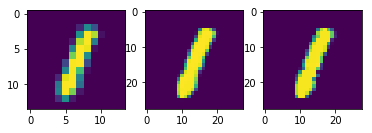

5700 [D loss: 0.693263, acc.: 55.50%] [G loss: 0.702700]


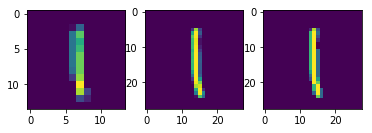

5800 [D loss: 0.693262, acc.: 34.00%] [G loss: 0.702653]


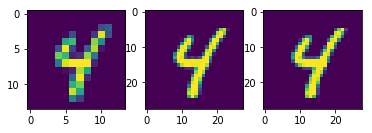

5900 [D loss: 0.693260, acc.: 49.50%] [G loss: 0.702458]


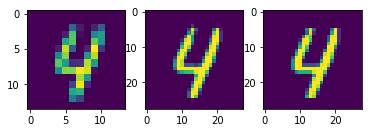

6000 [D loss: 0.693260, acc.: 45.00%] [G loss: 0.702466]


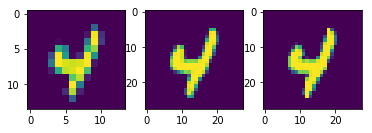

6100 [D loss: 0.693258, acc.: 46.50%] [G loss: 0.702590]


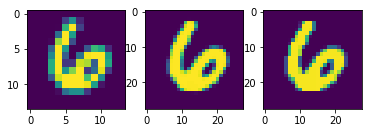

6200 [D loss: 0.693259, acc.: 32.00%] [G loss: 0.702575]


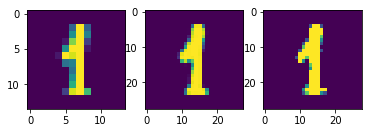

6300 [D loss: 0.693256, acc.: 41.00%] [G loss: 0.702150]


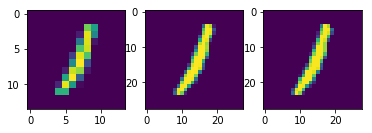

6400 [D loss: 0.693258, acc.: 70.50%] [G loss: 0.702131]


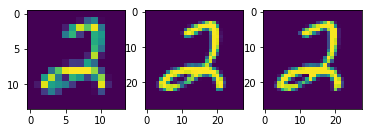

6500 [D loss: 0.693255, acc.: 44.50%] [G loss: 0.702593]


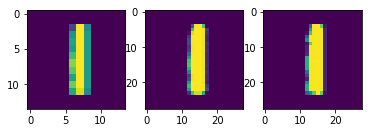

6600 [D loss: 0.693253, acc.: 49.00%] [G loss: 0.702493]


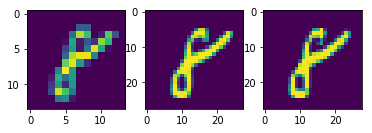

6700 [D loss: 0.693253, acc.: 33.00%] [G loss: 0.702263]


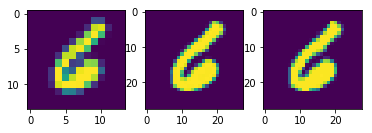

6800 [D loss: 0.693253, acc.: 51.50%] [G loss: 0.701935]


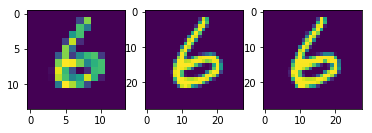

6900 [D loss: 0.693254, acc.: 39.50%] [G loss: 0.702434]


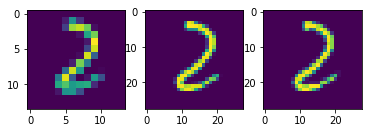

7000 [D loss: 0.693251, acc.: 63.50%] [G loss: 0.703140]


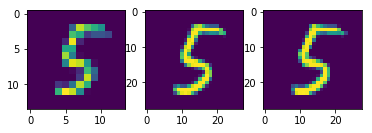

7100 [D loss: 0.693251, acc.: 70.50%] [G loss: 0.702267]


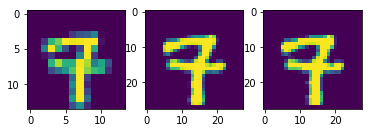

7200 [D loss: 0.693248, acc.: 61.50%] [G loss: 0.702422]


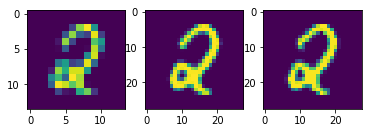

7300 [D loss: 0.693247, acc.: 33.50%] [G loss: 0.702671]


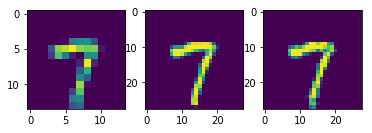

7400 [D loss: 0.693246, acc.: 60.00%] [G loss: 0.703500]


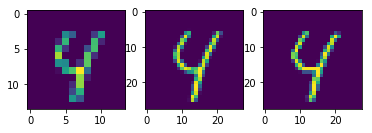

7500 [D loss: 0.693245, acc.: 47.50%] [G loss: 0.702144]


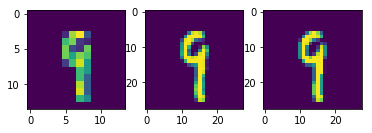

7600 [D loss: 0.693244, acc.: 39.50%] [G loss: 0.701957]


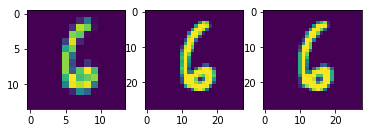

7700 [D loss: 0.693244, acc.: 68.50%] [G loss: 0.702207]


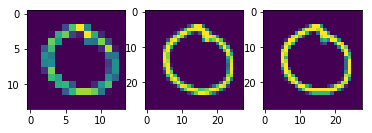

7800 [D loss: 0.693242, acc.: 39.50%] [G loss: 0.701343]


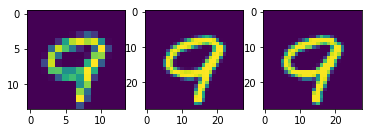

7900 [D loss: 0.693241, acc.: 40.50%] [G loss: 0.702006]


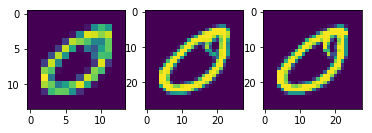

8000 [D loss: 0.693241, acc.: 61.50%] [G loss: 0.701911]


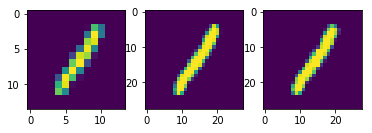

8100 [D loss: 0.693240, acc.: 32.00%] [G loss: 0.702199]


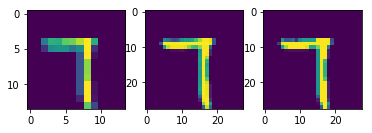

8200 [D loss: 0.693238, acc.: 28.50%] [G loss: 0.702291]


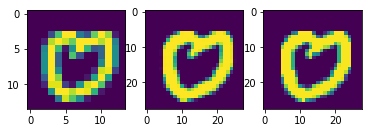

8300 [D loss: 0.693238, acc.: 63.00%] [G loss: 0.701523]


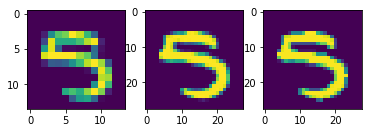

8400 [D loss: 0.693236, acc.: 61.50%] [G loss: 0.702502]


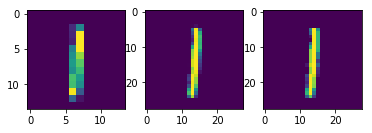

8500 [D loss: 0.693236, acc.: 42.50%] [G loss: 0.701952]


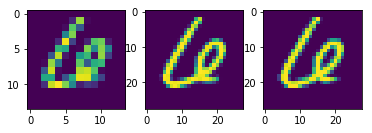

8600 [D loss: 0.693240, acc.: 31.00%] [G loss: 0.701743]


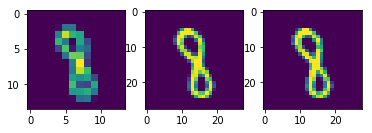

8700 [D loss: 0.693233, acc.: 38.50%] [G loss: 0.701387]


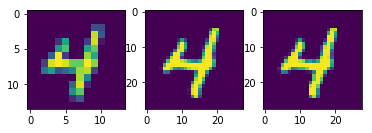

8800 [D loss: 0.693234, acc.: 66.50%] [G loss: 0.702276]


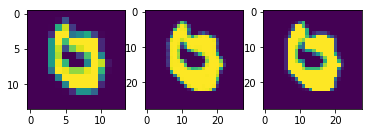

8900 [D loss: 0.693231, acc.: 37.00%] [G loss: 0.701906]


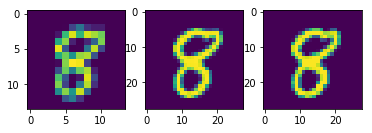

9000 [D loss: 0.693231, acc.: 31.50%] [G loss: 0.702372]


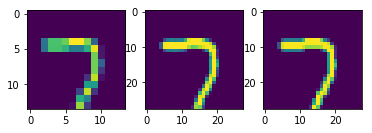

9100 [D loss: 0.693230, acc.: 29.50%] [G loss: 0.701939]


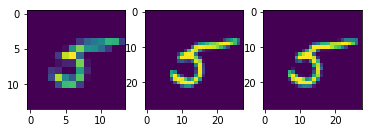

9200 [D loss: 0.693229, acc.: 33.00%] [G loss: 0.701867]


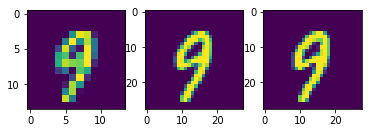

9300 [D loss: 0.693230, acc.: 71.00%] [G loss: 0.701975]


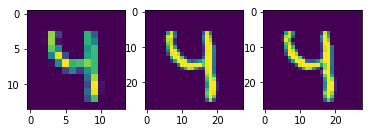

9400 [D loss: 0.693227, acc.: 64.00%] [G loss: 0.701771]


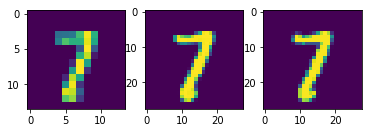

9500 [D loss: 0.693226, acc.: 59.50%] [G loss: 0.701293]


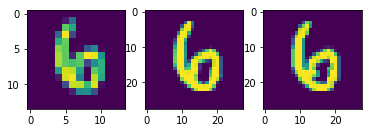

9600 [D loss: 0.693227, acc.: 72.50%] [G loss: 0.702054]


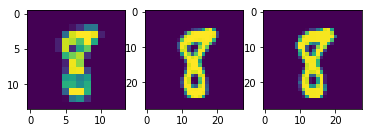

9700 [D loss: 0.693224, acc.: 55.00%] [G loss: 0.701656]


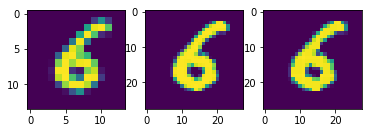

9800 [D loss: 0.693224, acc.: 47.50%] [G loss: 0.701755]


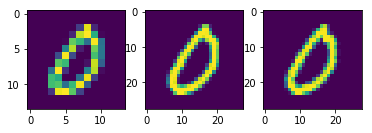

9900 [D loss: 0.693225, acc.: 32.00%] [G loss: 0.702069]


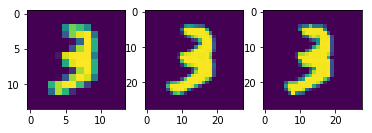

10000 [D loss: 0.693222, acc.: 62.50%] [G loss: 0.701432]


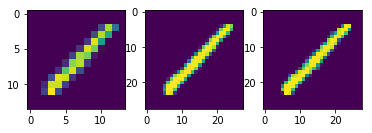

In [6]:
epochs = 10000
batch_size = 200
half_batch = int(batch_size/2)

def reduce_resolution(ims):
    O, M, N, P = ims.shape
    K = 2
    L = 2

    MK = M // K
    NL = N // L
    return ims.reshape(-1, MK, K, NL, L).mean(axis=(2, 4)).reshape(O, MK, NL, P)

# Unused function...?
def upsize(ims):
    return ims.repeat(2, axis = 1).repeat(2, axis = 2)

for epoch in range(1, epochs + 1):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    idx1 = np.random.randint(0, X_train.shape[0], half_batch)
    imgs1 = X_train[idx1]
    noise1 = reduce_resolution(imgs1)

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise1)
    # gen_imgs are now upsampled to original resolution
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    idx2 = np.random.randint(0, X_train.shape[0], batch_size)
    noise2 = reduce_resolution(X_train[idx2])

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)
    
    # Train the generator
    g_loss = combined.train_on_batch(noise2, [valid_y, X_train[idx2]])
        
    if epoch % 100 == 0:
        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(np.reshape(noise1[0], (14, 14)))
        ax[1].imshow(np.reshape(gen_imgs[0], (28, 28)))
        ax[2].imshow(np.reshape(imgs1[0], (28, 28)))
        plt.show()


In [7]:
generator.save('./models/generator_mnist.h5')
discriminator.save('./models/discriminator_mnist.h5')
combined.save('./models/combined_mnist.h5')

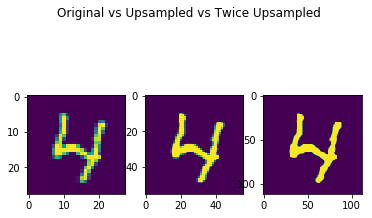

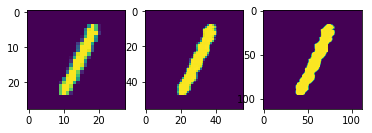

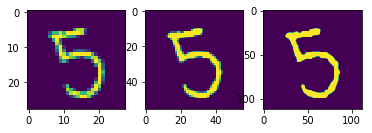

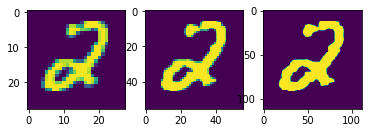

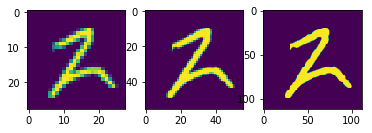

In [11]:
from keras.models import load_model

# Load the model
generator = load_model('./models/generator_mnist.h5')

# Upsample five images
fi = 314 # First index
images = X_train[fi:fi + 5]
upsampled = generator.predict(images)
upupsampled = generator.predict(upsampled)

# Create a figure showing the results
for i, (original, up, upup) in enumerate(zip(images, upsampled, upupsampled)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    if i == 0:
        fig.suptitle("Original vs Upsampled vs Twice Upsampled")
    ax1.imshow(original[:, :, 0])
    ax2.imshow(up[:, :, 0])
    ax3.imshow(upup[:, :, 0])
    plt.show()